In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from contractions import CONTRACTION_MAP
from re import compile, IGNORECASE, DOTALL, sub, escape
from string import punctuation
import numpy as np
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

import pprint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import naive_bayes
from sklearn.metrics import classification_report

import time
import random
random.seed(2018)

In [2]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens

In [3]:
stopword_list = stopwords.words('english') # nltk.download()
wnl = WordNetLemmatizer()

In [4]:
def expand_contractions(text, contraction_mapping):
    contractions_pattern = compile('({})'.format('|'.join(contraction_mapping.keys())),flags=IGNORECASE | DOTALL)
    
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) \
            if contraction_mapping.get(match) \
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = sub("'", "", expanded_text)
    return expanded_text

In [5]:
def remove_stopwords(text):
    words = tokenize_text(text)
    filtered_tokens = [word for word in words if word not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [6]:
def remove_special_characters(text):
    words = tokenize_text(text)
    pattern = compile('[{}]'.format(escape(punctuation)))
    filtered_words = filter(None, [pattern.sub('', word) for word in words])
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [7]:
def normalize_corpus(corpus, tokenize=False):
    normalized_corpus = []    
    for text in corpus:
        text = expand_contractions(text, CONTRACTION_MAP)
#        text = lemmatize_text(text)
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        if tokenize:
            text = tokenize_text(text)
            normalized_corpus.append(text)
        else:
            normalized_corpus.append(text)
    return normalized_corpus

In [8]:
d1 = pd.read_csv("Medicare_National_HCPCS_Aggregate_Summary_Table_CY2015.csv")
d1 = d1[(d1.iloc[:,2] == 'N ')] # & (d1.iloc[:,3] == 'O ')
d1.head(2)

,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Place of Service,Number of Providers,Number of Services,Number of Unique Beneficiary/Provider Interactions,Number of Distinct Medicare Beneficiary/Per Day Services,Average Submitted Charge Amount,Average Medicare Allowed Amount,Average Medicare Payment Amount,Average Medicare Standardized Payment Amount
0,00100,Anesthesia for procedure on salivary gland wit...,N,F,9552,12180,12150,12174,1618.30,239.13,185.37,186.39
1,00100,Anesthesia for procedure on salivary gland wit...,N,O,10,12,12,12,850.24,207.42,162.61,167.26


In [9]:
d2 = d1.iloc[:,[1,3,11]]
d2.iloc[:,0] = d2.iloc[:,0].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
d2.iloc[:,0] = d2.iloc[:,0].apply(lambda x: re.sub('  ',' ', x))
d2.head(2)

C:\Users\sande\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,HCPCS Description,Place of Service,Average Medicare Standardized Payment Amount
0,anesthesia for procedure on salivary gland wit...,F,186.39
1,anesthesia for procedure on salivary gland wit...,O,167.26


In [10]:
d2= d2.assign(PriceRange=np.nan)
d2.loc[d2.iloc[:,2]<d2.iloc[:,2].quantile(.2),'PriceRange'] = '1.veryLow'
d2.loc[(d2.iloc[:,2]<d2.iloc[:,2].quantile(.4))& (d2.iloc[:,2]>=d2.iloc[:,2].quantile(.2)),'PriceRange']='2.Low'
d2.loc[(d2.iloc[:,2]<d2.iloc[:,2].quantile(.6))& (d2.iloc[:,2]>=d2.iloc[:,2].quantile(.4)),'PriceRange']='3.Middle'
d2.loc[(d2.iloc[:,2]<d2.iloc[:,2].quantile(.8))& (d2.iloc[:,2]>=d2.iloc[:,2].quantile(.6)),'PriceRange']='4.High'
d2.loc[d2.iloc[:,2]>=d2.iloc[:,2].quantile(.8),'PriceRange']='5.veryHigh'
d2.head(2)

,HCPCS Description,Place of Service,Average Medicare Standardized Payment Amount,PriceRange
0,anesthesia for procedure on salivary gland wit...,F,186.39,3.Middle
1,anesthesia for procedure on salivary gland wit...,O,167.26,3.Middle


In [11]:
d2['PriceRange']=d2['PriceRange'].astype('category')
Cat_type = CategoricalDtype(categories=list(['1.veryLow','2.Low','3.Middle','4.High','5.veryHigh']), ordered=True)
d2['PriceRange']=d2['PriceRange'].astype(Cat_type)

(array([1545.,  887.,  746.,  596.,  497.,  424.,  426.,  389.,  329.,
        326.,  280.,  290.,  270.,  261.,  250.,  234.,  235.,  198.,
        174.,  177.,  164.,  155.,  152.,  112.,  116.,  112.,  117.,
         92.,   90.,   79.]), array([ 17.29      ,  41.69966667,  66.10933333,  90.519     ,
       114.92866667, 139.33833333, 163.748     , 188.15766667,
       212.56733333, 236.977     , 261.38666667, 285.79633333,
       310.206     , 334.61566667, 359.02533333, 383.435     ,
       407.84466667, 432.25433333, 456.664     , 481.07366667,
       505.48333333, 529.893     , 554.30266667, 578.71233333,
       603.122     , 627.53166667, 651.94133333, 676.351     ,
       700.76066667, 725.17033333, 749.58      ]), <a list of 30 Patch objects>)


C:\Users\sande\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


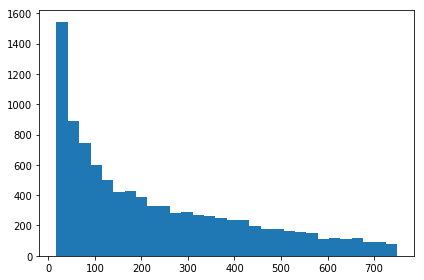

In [12]:
d2 = d2[(d2.iloc[:,2] < d2.iloc[:,2].quantile(.9))&(d2.iloc[:,2] > d2.iloc[:,2].quantile(.1))]
fig, axs = plt.subplots(1,1, sharey=True, tight_layout=True)
print(axs.hist(d2.iloc[:,2], bins=30))

(-0.5, 999.5, 499.5, -0.5)

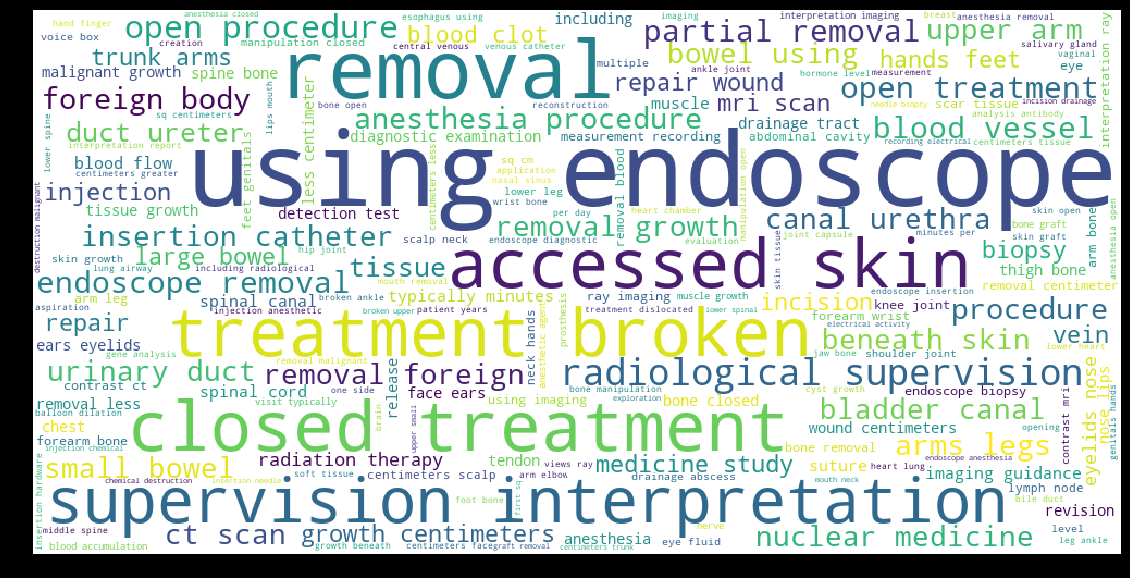

In [13]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color="white",stopwords=stopwords,
                      random_state = 2018,width=1000
                      , height=500).generate(" ".join([i for i in d2.iloc[:,0]]))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")

In [14]:
train, validate = train_test_split(d2, test_size=.10, random_state=0)
train, validate = train.copy(), validate.copy()

In [15]:
train['ind'] = range(train.iloc[:,0].count())
train = train.set_index(['ind'])
train = pd.concat([train, pd.get_dummies(train['Place of Service'], drop_first= True)], axis = 1)
train = train.drop(['Place of Service'], axis = 1)

validate['ind'] = range(validate.iloc[:,0].count())
validate = validate.set_index(['ind'])
validate = pd.concat([validate, pd.get_dummies(validate['Place of Service'], drop_first= True)], axis = 1)
validate = validate.drop(['Place of Service'], axis = 1)

In [16]:
train.head(2)

,HCPCS Description,Average Medicare Standardized Payment Amount,PriceRange,O
ind,,,,
0,repair of hernia between abdominal muscles,417.21,4.High,0
1,lengthening of calf muscle,277.81,4.High,0


In [17]:
train_text_norm = normalize_corpus(train.iloc[:,0], tokenize=False)
train_target = train['Average Medicare Standardized Payment Amount']
train_target_cat = train['PriceRange']

validate_text_norm = normalize_corpus(validate.iloc[:,0], tokenize=False)
validate_target = validate['Average Medicare Standardized Payment Amount']
validate_target_cat = validate['PriceRange']

In [55]:
# Tuning parameters using a pipeline

pipeline = Pipeline([("vect", TfidfVectorizer(max_features=10000)),
                     ("model", RandomForestRegressor(random_state=0))])
parameters = {
    "vect__ngram_range": [(1, 1),(1, 2),(1, 3),(1,4)],  
    "vect__max_df": [.99,0.95,0.90],
    "vect__min_df": [.01, 0.05, 0.1],
    "model__n_estimators": [60, 50, 30, 10],
    "model__max_depth": [40, 30, 20 , 10]
}
grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=3)
start = time.time()
grid.fit(train_text_norm, train_target)
stop = time.time()
print("total time: ", stop-start)

total time:  1232.1315491199493


In [56]:
# Analyze results
pprint.pprint(grid.best_params_)
# Generate predictions
model = grid.best_estimator_
predict = cross_val_predict(model, train_text_norm, train_target, cv=5, n_jobs=3)
predict_processed = [int(round(i)) for i in predict]
train_target_processed = [int(round(i)) for i in train_target]
# Analyze accuracy
print("Accuracy: %.2f" % (accuracy_score(train_target_processed, predict_processed) * 100))
# Analyze Root Mean Squared Error
print("RMSE: %.2f "% np.sqrt(mean_squared_error(train_target, predict)))

{'model__max_depth': 40,
 'model__n_estimators': 60,
 'vect__max_df': 0.99,
 'vect__min_df': 0.01,
 'vect__ngram_range': (1, 2)}
Accuracy: 0.45
RMSE: 142.47 


In [57]:
Tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),stop_words="english", max_df=.99, min_df=.01)
train_Tfidf_vectorized = Tfidf_vectorizer.fit_transform(train_text_norm)
train_Tfidf_vectorized_array = train_Tfidf_vectorized.toarray()
print("Here is the array shape \n", train_Tfidf_vectorized_array.shape, "\n")
features = Tfidf_vectorizer.get_feature_names()
#print("Here are the features extracted \n", features, "\n")
print("Here is what goes into the model \n", 
      pd.DataFrame(data=train_Tfidf_vectorized_array[0:2, :], columns=features).head(2), "\n")

Here is the array shape 
 (8750, 168) 

Here is what goes into the model 
    abdominal  abnormal  abscess  accessed  accessed skin  analysis  andor  \
0   0.800133       0.0      0.0       0.0            0.0       0.0    0.0   
1   0.000000       0.0      0.0       0.0            0.0       0.0    0.0   

   anesthesia  anesthesia procedure  ankle  ...   urinary  urinary duct  \
0         0.0                   0.0    0.0  ...       0.0           0.0   
1         0.0                   0.0    0.0  ...       0.0           0.0   

   using  using endoscope  vaginal  vein  vessel  wound  wrist  xray  
0    0.0              0.0      0.0   0.0     0.0    0.0    0.0   0.0  
1    0.0              0.0      0.0   0.0     0.0    0.0    0.0   0.0  

[2 rows x 168 columns] 



In [58]:
validate_Tfidf_vectorized = Tfidf_vectorizer.transform(validate_text_norm)
validate_Tfidf_vectorized_array = validate_Tfidf_vectorized.toarray()
print("Here is the array shape \n", validate_Tfidf_vectorized_array.shape, "\n")
features = Tfidf_vectorizer.get_feature_names()

Here is the array shape 
 (973, 168) 



In [59]:
train_Tfidf_vectorized_df = pd.DataFrame(data=train_Tfidf_vectorized_array, columns=features)
train_Tfidf_vectorized_df['Place_O'] = train.iloc[:,3]
validate_Tfidf_vectorized_df = pd.DataFrame(data=validate_Tfidf_vectorized_array, columns=features)
validate_Tfidf_vectorized_df['Place_O'] = validate.iloc[:,3]

In [60]:
#Support Vector Classification extended to solve regression problems
clf = svm.SVR()
clf.fit(train_Tfidf_vectorized_df, train_target)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [81]:
train_pre_clf = clf.predict(train_Tfidf_vectorized_df)
train_pre_clf_processed = [int(round(i)) for i in train_pre_clf]
train_target_processed = [int(round(i)) for i in train_target]
print("Train_svm - Accuracy: %.3f " % (accuracy_score(train_pre_clf_processed,train_target_processed)))
print("Train_svm - RMSE: $%.2f " % np.sqrt(mean_squared_error(train_pre_clf_processed,train_target_processed)))
validate_pre_clf = clf.predict(validate_Tfidf_vectorized_df)
validate_pre_clf_processed = [int(round(i)) for i in validate_pre_clf]
validate_target_processed = [int(round(i)) for i in validate_target]
print("Validate_svm - Accuracy: %.3f " % (accuracy_score(validate_pre_clf_processed,validate_target_processed)))
print("Validate_svm - RMSE: $%.2f " % np.sqrt(mean_squared_error(validate_pre_clf_processed,validate_target_processed)))

Train_svm - Accuracy: 0.002 
Train_svm - RMSE: $201.67 
Validate_svm - Accuracy: 0.003 
Validate_svm - RMSE: $199.30 


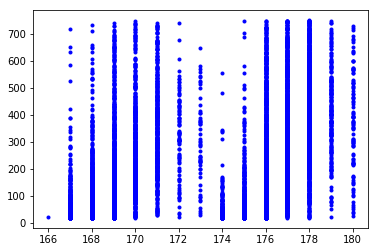

In [86]:
plt.plot(train_pre_clf_processed, train_target_processed, 'b.')

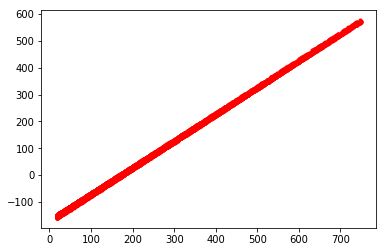

In [87]:
plt.plot(train_target,(train_target - train_pre_clf), 'r.')

In [82]:
# RandomForestRegressor 
# Cross-validate Predict 
model = RandomForestRegressor(n_estimators=60, max_depth=40)
predict = cross_val_predict(model, train_Tfidf_vectorized_df, train_target)
predict_processed = [int(round(i)) for i in predict]
# Analyze accuracy
print("Train_rfr - Accuracy: %.3f " % (accuracy_score(predict_processed,train_target_processed )))
# Analyze Root Mean Squared Error
print("Train_rfr - RMSE: $%.2f " % np.sqrt(mean_squared_error(predict, train_target)))

Train_rfr - Accuracy: 0.004 
Train_rfr - RMSE: $144.08 


In [83]:
predict2 = cross_val_predict(model, validate_Tfidf_vectorized_df, validate_target)
predict2_processed = [int(round(i)) for i in predict2]
# Analyze accuracy
print("Validate_rfr - Accuracy: %.3f " % (accuracy_score(predict2_processed, validate_target_processed ) ))
# Analyze Root Mean Squared Error
print("Validate_rfr - RMSE: $%.2f " % np.sqrt(mean_squared_error(predict2, validate_target)))

Validate_rfr - Accuracy: 0.003 
Validate_rfr - RMSE: $162.53 


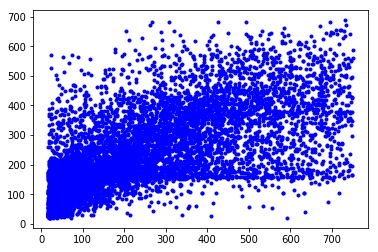

In [84]:
plt.plot(train_target, predict, 'b.')

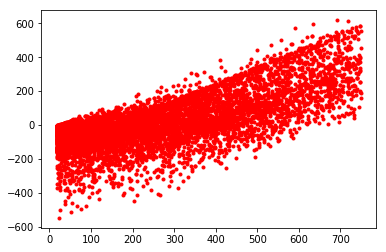

In [85]:
plt.plot(train_target,(train_target - predict), 'r.')

In [72]:
# Classification Logistic Regression
clfrLR = LogisticRegression()
clfrLR.fit(train_Tfidf_vectorized_df, train_target_cat)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [73]:
train_predict_prices = clfrLR.predict(train_Tfidf_vectorized_df)
print("Logistic Regression - Training data")
print(classification_report(train_target_cat, train_predict_prices))
feature_names= np.array(features)
sored_coef_index = clfrLR.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sored_coef_index[:15]]))
print('Largest Coefs:\n{}\n'.format(feature_names[sored_coef_index[:-15:-1]]))

Logistic Regression - Training data
             precision    recall  f1-score   support

  1.veryLow       0.61      0.43      0.50      1076
      2.Low       0.48      0.62      0.54      2184
   3.Middle       0.46      0.42      0.44      2197
     4.High       0.47      0.58      0.52      2185
 5.veryHigh       0.49      0.20      0.29      1108

avg / total       0.49      0.48      0.47      8750

Smallest Coefs:
['removal' 'repair' 'anesthesia' 'endoscope' 'incision' 'artery'
 'drainage' 'upper' 'using endoscope' 'open' 'graft' 'destruction'
 'radiation' 'insertion' 'release']

Largest Coefs:
['xray' 'level' 'measurement' 'test' 'ultrasound' 'analysis' 'tube'
 'interpretation' 'physician' 'minutes' 'imaging' 'therapy' 'examination'
 'supervision']



In [74]:
validate_predict_prices = clfrLR.predict(validate_Tfidf_vectorized_df)
print("Logistic Regression - Validatiton data")
print(classification_report(validate_target_cat, validate_predict_prices))

Logistic Regression - Validatiton data
             precision    recall  f1-score   support

  1.veryLow       0.64      0.45      0.53       135
      2.Low       0.51      0.63      0.56       248
   3.Middle       0.45      0.40      0.42       235
     4.High       0.48      0.60      0.53       247
 5.veryHigh       0.34      0.16      0.22       108

avg / total       0.48      0.49      0.48       973



In [75]:
# Classification naive bayes classifier
clfrNB = naive_bayes.MultinomialNB()
clfrNB.fit(train_Tfidf_vectorized_df, train_target_cat)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [76]:
train_predict_prices = clfrNB.predict(train_Tfidf_vectorized_df)
print("Naive Bayes - Training data")
print(classification_report(train_target_cat, train_predict_prices))

Naive Bayes - Training data
             precision    recall  f1-score   support

  1.veryLow       0.56      0.41      0.47      1076
      2.Low       0.46      0.54      0.50      2184
   3.Middle       0.39      0.35      0.37      2197
     4.High       0.44      0.63      0.52      2185
 5.veryHigh       0.48      0.13      0.20      1108

avg / total       0.45      0.45      0.43      8750



In [77]:
validate_predict_prices = clfrNB.predict(validate_Tfidf_vectorized_df)
print("Naive Bayes - Validatiton data")
print(classification_report(validate_target_cat, validate_predict_prices))

Naive Bayes - Validatiton data
             precision    recall  f1-score   support

  1.veryLow       0.56      0.44      0.49       135
      2.Low       0.49      0.57      0.53       248
   3.Middle       0.39      0.31      0.35       235
     4.High       0.45      0.66      0.53       247
 5.veryHigh       0.26      0.06      0.10       108

avg / total       0.44      0.46      0.43       973



In [78]:
# Classification support vector machine
clfrSVM = svm.SVC(kernel = 'linear', C = 0.1) #suport vector classifier 
clfrSVM.fit(train_Tfidf_vectorized_df, train_target_cat)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [79]:
train_predict_prices = clfrSVM.predict(train_Tfidf_vectorized_df)
print("Support vector machine - Training data")
print(classification_report(train_target_cat, train_predict_prices))

sored_coef_index = clfrSVM.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sored_coef_index[:15]]))
print('Largest Coefs:\n{}\n'.format(feature_names[sored_coef_index[:-15:-1]]))

Support vector machine - Training data
             precision    recall  f1-score   support

  1.veryLow       0.74      0.27      0.40      1076
      2.Low       0.45      0.64      0.53      2184
   3.Middle       0.43      0.44      0.44      2197
     4.High       0.46      0.63      0.53      2185
 5.veryHigh       0.00      0.00      0.00      1108

avg / total       0.43      0.46      0.42      8750

Smallest Coefs:
['detection' 'needle' 'canal' 'recording' 'contrast' 'radiological'
 'radiological supervision' 'upper' 'supervision interpretation' 'bowel'
 'spinal' 'anesthesia' 'mri' 'lower' 'graft']

Largest Coefs:
['level' 'measurement' 'xray' 'analysis' 'test' 'small' 'stomach' 'bones'
 'elbow' 'face' 'bladder canal' 'canal urethra' 'chest' 'hip']



C:\Users\sande\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [80]:
validate_predict_prices = clfrSVM.predict(validate_Tfidf_vectorized_df)
print("Support vector machine - Validate data")
print(classification_report(validate_target_cat, validate_predict_prices))

Support vector machine - Validate data
             precision    recall  f1-score   support

  1.veryLow       0.72      0.28      0.40       135
      2.Low       0.48      0.69      0.57       248
   3.Middle       0.45      0.43      0.44       235
     4.High       0.47      0.66      0.55       247
 5.veryHigh       0.00      0.00      0.00       108

avg / total       0.45      0.49      0.45       973



C:\Users\sande\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
